In [22]:
import os
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by 30 to 60MB if set to True; size is <1MB otherwise

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    print('\n \n To load files from Google Drive, account validation is required.')
    # mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils

elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio==1.0.0
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils Utils


else:
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately

import ReadData.RawDataReader as data_reader
if 'KAGGLE_URL_BASE' in os.environ:
    import Utils.ModelBuilder as model_builder
    import Utils.ChartBuilder as chart_builder
else:
    import utils.ModelBuilder as model_builder
    import utils.ChartBuilder as chart_builder


Using homepath \Users\marit


In [10]:
#reload(data_reader)
ignore_list = ['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250 # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4']#F8'

chans=len(all_channels) - len(excluded_channels)

data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels, time_window)

Minimum duration:  740


'Shape of raw data for healthy controls: '

(14, 125001, 11)

'Shape of raw data for schizophrenic patients: '

(12, 125001, 11)

Selecting training  / testing / validation sets randomly from patient data
Splitting data into time windows to improve stability of results
(10, 125001, 11)
(250, 5000, 11)
Shape of X_train:  (450, 5000, 11)
Shape of X_validate:  (100, 5000, 11)
Shape of X_test:  (100, 5000, 11)
Selected indexes for control group: 
Training:  [4, 7, 13, 2, 9, 6, 3, 1, 0, 5]
Testing:  [11, 10]
Validation:  [8, 12]

Selected indexes for patient group: 
Training:  [9, 5, 1, 7, 10, 0, 3, 4]
Testing:  [2, 8]
Validation:  [11, 6]


In [ ]:
if plot_examples:
    random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [15]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

# adapted from https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
def CNN(time_steps, nb_features, chans, nb_classes=2, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout1D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout1D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (time_steps, chans))
    
    pooling_layer1_format = 'channels_first'
    pooling_layer2_format = 'channels_last'
   

    ##################################################################
    block1       = Conv1D(F1, (kernLength), padding = 'same',
                                  # input_shape = ( chans, samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = -1)(block1)
   
    block1       = Conv1D(5, (chans), padding='same',
                          use_bias = False )(block1)
    block1       = BatchNormalization(axis = -1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling1D(pool_size=(4),  name='apl1')(block1)
    block1       = dropoutType(dropoutRate)(block1)
 
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block1)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('elu')(block2)
    #block2       = AveragePooling1D(pool_size=(3), name='apl2')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    
    
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block2)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('elu')(block2)
    block2       = dropoutType(dropoutRate)(block2)
 
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [62]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

def Simple_CNN(time_steps,  chans, nb_classes=2, 
             dropoutRate = 0.5, kernLength = 64):
    
    input1   = Input(shape = (time_steps, chans))
    #try kernel size of 4 and filter size of 2; or try to use kernel size of 32 and filter size of 8 or 16; add more epochs; increase learning rate
    block       = Conv1D(16, 4, activation='relu')(input1)
    block       = MaxPooling1D()(block)
    block       = Flatten()(block) 
    block       = Dropout(0.4)(block)
    #block       = Dense(10, activation='relu', name = 'dense10' )(block)
    block       = Dense(nb_classes, activation='sigmoid', name = 'dense2' )(block)

    
    return Model(inputs=input1, outputs=block)

In [63]:
chans=len(all_channels) - len(excluded_channels)
sm = Simple_CNN(time_steps=time_window, chans=chans)
cnn_opt_adam = tf.keras.optimizers.Adam(lr=0.00002, 
                                beta_1=0.95,
                                beta_2=0.99,
                                epsilon=1e-07)
cnn_checkpoint = '/tmp/Simple_CNN_checkpoint.h5'
model = sm #dbg
simple_cnn_fitted_model = model_builder.construct_and_run_model(data, sm, cnn_opt_adam, cnn_checkpoint, 
                                                         epochs=60, batch_size=32, loss_type='binary_crossentropy')####


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 5000, 11)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 4997, 16)          720       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 2498, 16)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 39968)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 39968)             0         
_________________________________________________________________
dense2 (Dense)               (None, 2)                 79938     
Total params: 80,658
Trainable params: 80,658
Non-trainable params: 0
_________________________________________________________________
Train 

Epoch 38/60

Epoch 00038: val_loss did not improve from 0.54946
 - 2s - loss: 0.3445 - acc: 0.8667 - rmse: 0.3249 - val_loss: 0.5808 - val_acc: 0.7250 - val_rmse: 0.3714
Updated learning rate to  3.12499992105586e-07
Epoch 39/60

Epoch 00039: val_loss did not improve from 0.54946
 - 2s - loss: 0.3482 - acc: 0.8678 - rmse: 0.3115 - val_loss: 0.5800 - val_acc: 0.7250 - val_rmse: 0.4488
Epoch 40/60

Epoch 00040: val_loss did not improve from 0.54946
 - 2s - loss: 0.3435 - acc: 0.8789 - rmse: 0.3091 - val_loss: 0.5789 - val_acc: 0.7250 - val_rmse: 0.4045
Epoch 41/60

Epoch 00041: val_loss did not improve from 0.54946
 - 2s - loss: 0.3413 - acc: 0.8633 - rmse: 0.3202 - val_loss: 0.5780 - val_acc: 0.7250 - val_rmse: 0.4292
Epoch 42/60

Epoch 00042: val_loss did not improve from 0.54946
 - 2s - loss: 0.3463 - acc: 0.8689 - rmse: 0.3259 - val_loss: 0.5776 - val_acc: 0.7250 - val_rmse: 0.4432
Updated learning rate to  1.56249996052793e-07
Epoch 43/60

Epoch 00043: val_loss did not improve from 

In [ ]:
model_builder.print_model_metrics(simple_cnn_fitted_model, acc_key)


In [44]:
### CNN

# Declare model, optimizer and checkpoint file
cnn_model = CNN(time_steps=time_window, chans=chans, nb_features=1, nb_classes=2 )
cnn_opt_adam = tf.keras.optimizers.Adam(lr=0.00002, 
                                beta_1=0.95,
                                beta_2=0.99,
                                epsilon=1e-07)
cnn_checkpoint = '/tmp/CNN_checkpoint.h5'
model = cnn_model #dbg
cnn_fitted_model = model_builder.construct_and_run_model(data, cnn_model, cnn_opt_adam, cnn_checkpoint, epochs=200, batch_size=32)####


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 5000, 11)]        0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 5000, 8)           5632      
_________________________________________________________________
batch_normalization_88 (Batc (None, 5000, 8)           32        
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 5000, 5)           440       
_________________________________________________________________
batch_normalization_89 (Batc (None, 5000, 5)           20        
_________________________________________________________________
activation_66 (Activation)   (None, 5000, 5)           0         
_________________________________________________________________
apl1 (AveragePooling1D)      (None, 1250, 5)           0  


Epoch 00024: val_loss improved from 0.65331 to 0.65028, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.6354 - accuracy: 0.6578 - rmse: 0.4649 - val_loss: 0.6503 - val_accuracy: 0.6900 - val_rmse: 0.4865
Epoch 25/200

Epoch 00025: val_loss improved from 0.65028 to 0.64828, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.6335 - accuracy: 0.6600 - rmse: 0.4652 - val_loss: 0.6483 - val_accuracy: 0.7000 - val_rmse: 0.4864
Epoch 26/200

Epoch 00026: val_loss improved from 0.64828 to 0.64418, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.6339 - accuracy: 0.6533 - rmse: 0.4757 - val_loss: 0.6442 - val_accuracy: 0.7000 - val_rmse: 0.4850
Epoch 27/200

Epoch 00027: val_loss improved from 0.64418 to 0.64054, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.6290 - accuracy: 0.6800 - rmse: 0.4694 - val_loss: 0.6405 - val_accuracy: 0.7000 - val_rmse: 0.4840
Epoch 28/200

Epoch 00028: val_loss improved from 0.64054 to 0.63583, saving model to

Epoch 60/200

Epoch 00060: val_loss improved from 0.50913 to 0.50535, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.4883 - accuracy: 0.8489 - rmse: 0.3917 - val_loss: 0.5054 - val_accuracy: 0.7300 - val_rmse: 0.4437
Epoch 61/200

Epoch 00061: val_loss improved from 0.50535 to 0.50155, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.4803 - accuracy: 0.8600 - rmse: 0.3952 - val_loss: 0.5015 - val_accuracy: 0.7300 - val_rmse: 0.4418
Epoch 62/200

Epoch 00062: val_loss improved from 0.50155 to 0.49865, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.5042 - accuracy: 0.8111 - rmse: 0.4085 - val_loss: 0.4987 - val_accuracy: 0.7300 - val_rmse: 0.4408
Epoch 63/200

Epoch 00063: val_loss improved from 0.49865 to 0.49598, saving model to /tmp/CNN_checkpoint.h5
450/450 - 0s - loss: 0.4752 - accuracy: 0.8644 - rmse: 0.3900 - val_loss: 0.4960 - val_accuracy: 0.7400 - val_rmse: 0.4399
Epoch 64/200

Epoch 00064: val_loss improved from 0.49598 to 0.49473, sa

Epoch 97/200

Epoch 00097: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3678 - accuracy: 0.8778 - rmse: 0.3257 - val_loss: 0.4546 - val_accuracy: 0.7900 - val_rmse: 0.4052
Epoch 98/200

Epoch 00098: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3814 - accuracy: 0.8822 - rmse: 0.3475 - val_loss: 0.4558 - val_accuracy: 0.7800 - val_rmse: 0.4034
Updated learning rate to  9.999999747378752e-06
Epoch 99/200

Epoch 00099: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3631 - accuracy: 0.9156 - rmse: 0.3247 - val_loss: 0.4562 - val_accuracy: 0.7800 - val_rmse: 0.4028
Epoch 100/200

Epoch 00100: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3601 - accuracy: 0.8844 - rmse: 0.3196 - val_loss: 0.4570 - val_accuracy: 0.7900 - val_rmse: 0.4026
Epoch 101/200

Epoch 00101: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3488 - accuracy: 0.9089 - rmse: 0.3216 - val_loss: 0.4574 - val_accuracy: 0.7900 - val_rmse: 0.4025
Epoch 102/

Epoch 138/200

Epoch 00138: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3683 - accuracy: 0.8778 - rmse: 0.3320 - val_loss: 0.4596 - val_accuracy: 0.8000 - val_rmse: 0.3981
Updated learning rate to  9.765624753299562e-09
Epoch 139/200

Epoch 00139: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3701 - accuracy: 0.8778 - rmse: 0.3282 - val_loss: 0.4591 - val_accuracy: 0.7900 - val_rmse: 0.3985
Epoch 140/200

Epoch 00140: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3512 - accuracy: 0.8933 - rmse: 0.3085 - val_loss: 0.4593 - val_accuracy: 0.8000 - val_rmse: 0.3983
Epoch 141/200

Epoch 00141: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3506 - accuracy: 0.8978 - rmse: 0.3141 - val_loss: 0.4593 - val_accuracy: 0.8000 - val_rmse: 0.3983
Epoch 142/200

Epoch 00142: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3622 - accuracy: 0.8956 - rmse: 0.3285 - val_loss: 0.4590 - val_accuracy: 0.7900 - val_rmse: 0.3985
Updated

Updated learning rate to  9.536742923144104e-12
Epoch 179/200

Epoch 00179: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3658 - accuracy: 0.8800 - rmse: 0.3234 - val_loss: 0.4586 - val_accuracy: 0.7900 - val_rmse: 0.3988
Epoch 180/200

Epoch 00180: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3600 - accuracy: 0.8867 - rmse: 0.3332 - val_loss: 0.4589 - val_accuracy: 0.7900 - val_rmse: 0.3985
Epoch 181/200

Epoch 00181: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3512 - accuracy: 0.8956 - rmse: 0.3338 - val_loss: 0.4587 - val_accuracy: 0.7900 - val_rmse: 0.3987
Epoch 182/200

Epoch 00182: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3633 - accuracy: 0.8733 - rmse: 0.3160 - val_loss: 0.4588 - val_accuracy: 0.7900 - val_rmse: 0.3986
Updated learning rate to  4.768371461572052e-12
Epoch 183/200

Epoch 00183: val_loss did not improve from 0.45235
450/450 - 0s - loss: 0.3630 - accuracy: 0.9067 - rmse: 0.3164 - val_loss: 0.4587 -

Diagrammed History of Model Metrics


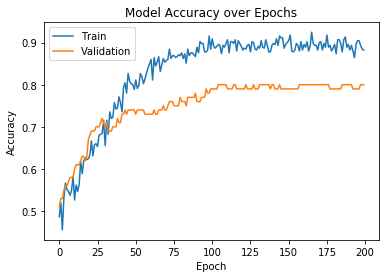

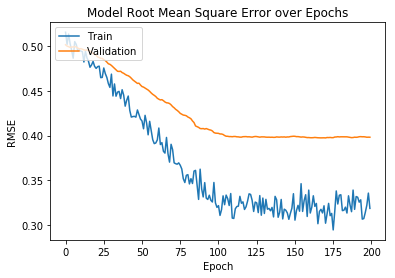

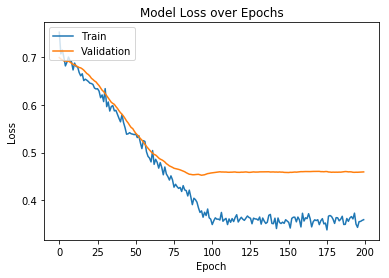

In [45]:
model_builder.print_model_metrics(cnn_fitted_model, acc_key)


In [46]:
!pip freeze

absl-py==0.9.0
affine==2.3.0
aiohttp==3.6.2
alabaster==0.7.12
albumentations==0.4.3
alembic==1.4.1
allennlp==0.9.0
altair==4.0.1
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
annoy==1.16.3
appdirs==1.4.3
arrow==0.15.5
arviz==0.7.0
asn1crypto==1.3.0
astor==0.8.1
astroid==2.3.3
astropy==3.2.3
async-timeout==3.0.1
atomicwrites==1.3.0
attr==0.3.1
attrs==19.3.0
audioread==2.1.8
aws-requests-auth==0.4.2
Babel==2.8.0
backcall==0.1.0
backports.functools-lru-cache==1.6.1
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
Baker==1.3
basemap==1.2.0
bayesian-optimization==1.1.0
bayespy==0.5.19
bcolz==1.2.1
beautifulsoup4==4.8.2
biopython==1.76
bitarray==1.2.1
bkcharts==0.2
bleach==3.1.0
blis==0.4.1
bokeh==1.4.0
Boruta==0.3
boto==2.49.0
boto3==1.12.13
botocore==1.15.13
Bottleneck==1.3.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplot==0.12.4


In [47]:
from platform import python_version

print(python_version())

3.6.6
